**資科工碩 0756110 李東霖**

# Introduction


In this lab, we need to implement NN and back propagation

Some request:

- Write a simple neural networks without framework (e.g. Tensorflow, PyTorch)
- Only use Numpy and other standard lib
- NN with two hidden layers
- Plot your comparison figure that show the predict result and ground truth

## Implementation

- $X$,$\hat{y}$ : Data
- $x_1$,$x_2$ : NN inputs
- $y$ : NN output
- $L(\theta)$ : Lost function (MSE $E(|\hat{y} - y|^2)$)
- $W$ : weight matrix
- $\sigma$ : activation function (sigmoid $\frac{1}{1+e^{-x}}$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Dataset

We have two data generator

- Linear
- XOR

Target y is 0 or 1, just like one class classification.

In [2]:
def show_result(x, y, pred_y):
    pred_y = np.round(pred_y)
    cm = LinearSegmentedColormap.from_list(
        'mymap', [(1, 0, 0), (0, 0, 1)], N=2)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Ground truth', fontsize=18)
    plt.scatter(x[:,0], x[:,1], c=y[:,0], cmap=cm)
    
    plt.subplot(1,2,2)
    plt.title('Predict result', fontsize=18)
    plt.scatter(x[:,0], x[:,1], c=pred_y[:,0], cmap=cm)
    
    plt.show()
    
def show_data(xs, ys, ts):
    cm = LinearSegmentedColormap.from_list(
        'mymap', [(1, 0, 0), (0, 0, 1)], N=2)
    n = len(xs)
    plt.figure(figsize=(5*n, 5))
    for i, x, y, t in zip(range(n), xs, ys, ts):
        y = np.round(y)
        plt.subplot(1,n, i+1)
        plt.title(t, fontsize=18)
        plt.scatter(x[:,0], x[:,1], c=y[:,0], cmap=cm)
    
    plt.show()

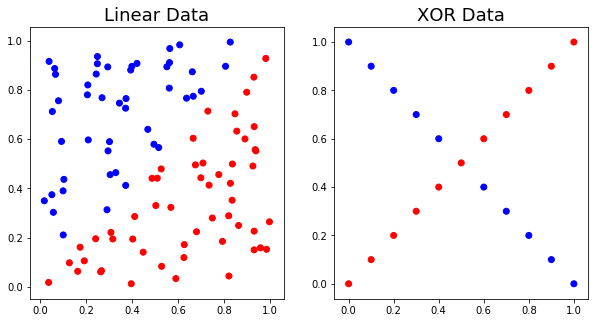

In [3]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy(n=11):
    inputs = []
    labels = []
    step = 1/(n-1)
    for i in range(n):
        inputs.append([step*i, step*i])
        labels.append(0)
        
        if i == int((n-1)/2):
            continue
        
        inputs.append([step*i, 1 - step*i])
        labels.append(1)
        
    return np.array(inputs), np.array(labels).reshape(n*2 - 1,1)

x1, y1 = generate_linear()
x2, y2 = generate_XOR_easy()
show_data([x1,x2], [y1,y2], ['Linear Data', 'XOR Data'])

# Experiment setups

## Activation function $\sigma$ (Sigmoid)

In this lab, I use Sigmoid function as my activation function

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

$$ \sigma'(x) = \frac{d (1 + e^{-x})^{-1}}{d x} $$

$$ = - (1 + e^{-x})^2 \frac{d}{dx} (1 + e^{-x}) $$

$$ = - (1 + e^{-x})(1 + e^{-x}) (-e^{-x}) $$

$$ = \sigma(x)(1 - \sigma(x))$$

implement reference from TAs.

In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)

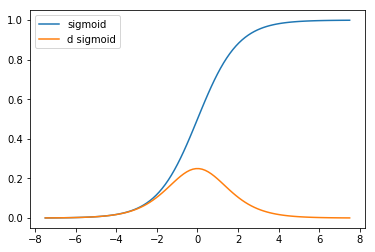

In [5]:
x = np.linspace(-7.5, 7.5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, derivative_sigmoid(sigmoid(x)), label='d sigmoid')
plt.legend()

## Loss function $L(\theta)$ (MSE)

In this lab, I use MSE (Mean Square Error) as my loss function.

$$ L(y, \hat{y}) = MSE(y,\hat(y)) = E((y - \hat{y})^2) = \frac{\sum (y - \hat{y})^2}{N} $$

$$ L'(y, \hat{y}) = \frac{\partial E((y - \hat{y})^2)}{\partial y} $$

$$ = \frac{1}{N}(\frac{\partial (y - \hat{y})^2}{\partial y}) $$

$$ = \frac{1}{N}(2(y - \hat{y})\frac{\partial (y - \hat{y})}{\partial y}) $$

$$ = \frac{2}{N}(y - \hat{y})$$

In [6]:
def loss(y, y_hat):
    return np.mean((y - y_hat)**2)
    
def derivative_loss(y, y_hat):
    return (y - y_hat)*(2/y.shape[0])

## Neural network

### Neural Unit

Our input $x$ vector get output $y$ scalar through neural unit 

$z=w^Tx+b, y=\sigma(z)$

Now extend neural unit as neural layer

### Neural Layer

One neural unit can output one scalar.
So if we want to output N scalar in this layer, we just put N units in layer.

explain some parameter in layer:

$w$ : weight matrix

- size is (input_size + 1, output_size)

- initialize $w$ in layer's `__init__`

- combine bias in $w$

$x$ : input vector

- size is (data_size, input_size)

- $x'$ automatically extend one columns for bias when `forward`

$z$ : $z = x'w$

- size is (data_size, output_size)

$y$ : $y = \sigma(z)$

- network output when output layer

- next layer input when hidden layer

$\frac{\partial C}{\partial w}, \frac{\partial z}{\partial w}, \frac{\partial C}{\partial z}$ : gradient matrix

- there are stored into layer parameter

- use to update $w$ when call `update`

Now, we see how to compute gradient from cost by using backpropagation

## Backpropagation

In the begining, all weight parameters in network are randomly initial.
And we want to minimize cost $C$ from loss function $L(\theta)$.


So we use gradient descent to update network's weights.
But $\frac{\partial C}{\partial w}$ is hard to compute.

Because of that, we use chain rules.

$$\frac{\partial C}{\partial w} = \frac{\partial z}{\partial w}\frac{\partial C}{\partial z}$$

### Forward

$$\frac{\partial z}{\partial w} = \frac{\partial x'w}{\partial w} = x'$$

So we can record $\frac{\partial z}{\partial w}$ as `forward_gradient` when call `forward`

And matrix size = (data_size, input_size+1)

### Backward

$$\frac{\partial C}{\partial z} = \frac{\partial y}{\partial z}\frac{\partial C}{\partial y}$$

we can get $\frac{\partial y}{\partial z}$ by:

$$y = \sigma(z), \space \frac{\partial y}{\partial z}=\sigma'(z)$$

We need to consider two case

- output layer:

we know $C$ is come from $L(\theta)$
$y$ is network output and $\hat{y}$ is groundtruth

$$ C = L(y, \hat{y}) \\ \frac{\partial C}{\partial y} = L'(y, \hat{y}) $$

we need to compute derivative loss function and then use it as backward input.

- hidden layer:

$\frac{\partial C}{\partial y}$ is more diffcult than other.

we know that this layer output $y$ will be input for next layer.
and we assume that $\frac{\partial C}{\partial z_{next}}$ already know.

$$\frac{\partial C}{\partial y_{this}} = \frac{\partial z_{next}}{\partial y_{this}}\frac{\partial C}{\partial z_{next}} $$

$$ \frac{\partial z_{next}}{\partial y_{this}} = w_{next}^T , z_{next} = y_{this}w_{next}$$

Finally, we first compute output layer and then send parameters to previous layer.
Thus we can compute $\frac{\partial C}{\partial z}$ every layer.

## Gradient Descent

Now we have $\frac{\partial C}{\partial w}$ and use it to update our network weights $w$.

we can put a new hyperparameter called learning rate $\eta$ to decide how fast

$$ w = w - \eta \Delta w$$

## implementation

I design a python class called `layer`.
`layer` will initialize all weights when create python class.
Every `layer` need two parameter `input_size` and `output_size`.

- `forward` function input $x$ and get output $y$.

- `backward` function input $\frac{\partial C}{\partial y}$ and get output $\frac{\partial C}{\partial x}$

- `update` function use gradient to update layer's weights

In [7]:
class layer():
    def __init__(self, input_size, output_size):
        self.w = np.random.normal(0, 1, (input_size+1, output_size))
        
    def forward(self, x):
        x = np.append(x, np.ones((x.shape[0],1)), axis=1)
        self.forward_gradient = x
        self.y = sigmoid(np.matmul(x, self.w))
        return self.y
    
    def backward(self, derivative_C):
        self.backward_gradient = np.multiply(
            derivative_sigmoid(self.y), 
            derivative_C
        )
        return np.matmul(self.backward_gradient, self.w[:-1].T) 

    def update(self, learning_rate):
        self.gradient = np.matmul(
            self.forward_gradient.T, 
            self.backward_gradient
        )
        self.w -= learning_rate*self.gradient
        return self.gradient

Now I can combine multi layers become Neural Network

I design a python class called `NN`. `NN` will create layers by `size` when create it.

- `forward` function positive sequence call all layer's `forward`, return final result

- `backward` function reverse call all layer's `backward`, return final result

- `update` function call all layer's `update`

In [8]:
class NN():
    def __init__(self, sizes, learning_rate = 0.1):
        self.learning_rate = learning_rate
        sizes2 = sizes[1:] + [0]
        self.l = []
        for a,b in zip(sizes, sizes2):
            if (a+1)*b == 0:
                continue
            self.l += [layer(a,b)]
            
    def forward(self, x):
        _x = x
        for l in self.l:
            _x = l.forward(_x)
        return _x
    
    def backward(self, dC):
        _dC = dC
        for l in self.l[::-1]:
            _dC = l.backward(_dC)
            
    def update(self):
        gradients = []
        for l in self.l:
            gradients += [l.update(self.learning_rate)]
        return gradients

# Results of your testing

In [9]:
nn_linear = NN([2,4,4,1], 1)
nn_XOR = NN([2,4,4,1], 1)
epoch_count = 10000
loss_threshold = 0.005
linear_stop = False
XOR_stop = False
x_linear, y_linear = generate_linear()
x_XOR, y_XOR = generate_XOR_easy()
for i in range(epoch_count):
    if not linear_stop:
        y = nn_linear.forward(x_linear)
        loss_linear = loss(y, y_linear)
        nn_linear.backward(derivative_loss(y, y_linear))
        nn_linear.update()
        
        if loss_linear < loss_threshold:
            print('linear is covergence')
            linear_stop = True
    
    if not XOR_stop:
        y = nn_XOR.forward(x_XOR)
        loss_XOR = loss(y, y_XOR)
        nn_XOR.backward(derivative_loss(y, y_XOR))
        nn_XOR.update()
        
        if loss_XOR < loss_threshold:
            print('XOR is covergence')
            XOR_stop = True

    if i%200 == 0 or (linear_stop and XOR_stop):
        print(
            '[{:4d}] linear loss : {:.4f} \t XOR loss : {:.4f}'.format(
                i, loss_linear, loss_XOR))
        
    if linear_stop and XOR_stop:
        break

[   0] linear loss : 0.3659 	 XOR loss : 0.2676
[ 200] linear loss : 0.0854 	 XOR loss : 0.2495
[ 400] linear loss : 0.0302 	 XOR loss : 0.2495
[ 600] linear loss : 0.0185 	 XOR loss : 0.2495
[ 800] linear loss : 0.0135 	 XOR loss : 0.2495
[1000] linear loss : 0.0108 	 XOR loss : 0.2495
[1200] linear loss : 0.0091 	 XOR loss : 0.2495
[1400] linear loss : 0.0080 	 XOR loss : 0.2495
[1600] linear loss : 0.0071 	 XOR loss : 0.2494
[1800] linear loss : 0.0065 	 XOR loss : 0.2494
[2000] linear loss : 0.0060 	 XOR loss : 0.2494
[2200] linear loss : 0.0056 	 XOR loss : 0.2494
[2400] linear loss : 0.0053 	 XOR loss : 0.2494
linear is covergence
[2600] linear loss : 0.0050 	 XOR loss : 0.2494
[2800] linear loss : 0.0050 	 XOR loss : 0.2494
[3000] linear loss : 0.0050 	 XOR loss : 0.2494
[3200] linear loss : 0.0050 	 XOR loss : 0.2493
[3400] linear loss : 0.0050 	 XOR loss : 0.2493
[3600] linear loss : 0.0050 	 XOR loss : 0.2493
[3800] linear loss : 0.0050 	 XOR loss : 0.2492
[4000] linear loss 

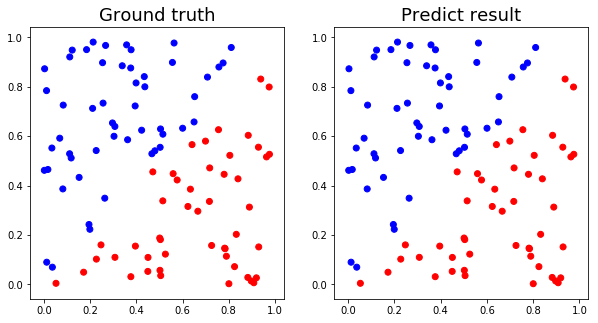

linear test loss :  0.004997369973721243


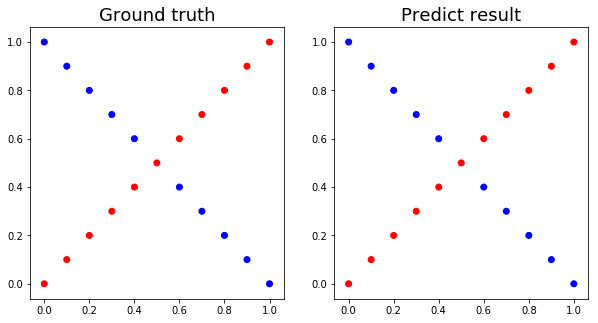

XOR test loss :  0.004985120154166471

 linear test result : 
 [[0.99853721]
 [0.00964757]
 [0.99905499]
 [0.00260557]
 [0.99884936]
 [0.78789472]
 [0.99880066]
 [0.00413509]
 [0.96854202]
 [0.00158948]
 [0.99879866]
 [0.99906358]
 [0.00248632]
 [0.00135504]
 [0.00401452]
 [0.00125463]
 [0.99881775]
 [0.99893572]
 [0.95260893]
 [0.00312461]
 [0.9990106 ]
 [0.01052388]
 [0.81454154]
 [0.94125602]
 [0.03221529]
 [0.00119163]
 [0.01460374]
 [0.00210475]
 [0.99886686]
 [0.9988201 ]
 [0.98402049]
 [0.00128568]
 [0.00199836]
 [0.8961942 ]
 [0.48680878]
 [0.99318262]
 [0.9983295 ]
 [0.00116607]
 [0.00120535]
 [0.00116337]
 [0.00415573]
 [0.93963421]
 [0.02561305]
 [0.00236981]
 [0.9990605 ]
 [0.92167761]
 [0.00231055]
 [0.99056011]
 [0.00659865]
 [0.00121181]
 [0.99894374]
 [0.9986065 ]
 [0.99893035]
 [0.00128212]
 [0.71270123]
 [0.99874477]
 [0.99905126]
 [0.99890611]
 [0.17191886]
 [0.99813572]
 [0.00117567]
 [0.99897263]
 [0.00135423]
 [0.98879932]
 [0.99843313]
 [0.99893673]
 [0.00162977]

In [10]:
y1 = nn_linear.forward(x_linear)
show_result(x_linear, y_linear, y1)
print('linear test loss : ', loss(y1, y_linear))
y2 = nn_XOR.forward(x_XOR)
show_result(x_XOR, y_XOR, y2)
print('XOR test loss : ', loss(y2, y_XOR))
print('\n linear test result : \n',y1)
print('\n XOR test result : \n',y2)

# Discussion

## Why perceptron can't classify XOR data but MLP can do ?


### Perceptron

Let us try to use perceptron to classify XOR data

And we can find that one perceptron only can have one decision boundary.

So XOR data can't be classified by one perceptron.

But if we has multi perceptron ?

In [11]:
def draw_decision_boundary(w):
    x = np.linspace(0,1,2)
    y = - (w[0] * x + w[2]) / w[1]
    plt.plot(x, y, '--', c='black')
    
def show_data_with_boundary(xs, ys, ts, w):
    cm = LinearSegmentedColormap.from_list(
        'mymap', [(1, 0, 0), (0, 0, 1)], N=2)
    n = len(xs)
    plt.figure(figsize=(5*n, 5))
    for i, x, y, t in zip(range(n), xs, ys, ts):
        y = np.round(y)
        plt.subplot(1,n, i+1)
        plt.title(t, fontsize=18)
        plt.scatter(x[:,0], x[:,1], c=y[:,0], cmap=cm)
        if "boundary" in t or "decision" in t:
            for i in range(w.shape[1]):
                draw_decision_boundary(w[:, i])
    plt.show()

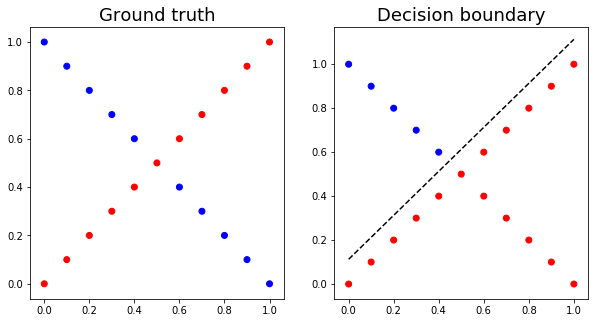

In [12]:
perceptron = NN([2,1], 10)
x_XOR, y_XOR = generate_XOR_easy()
for _ in range(10000):
    for i in range(x_XOR.shape[0]):
        y = perceptron.forward(x_XOR[i:i+1])
        loss_XOR = loss(y, y_XOR[i:i+1])
        perceptron.backward(derivative_loss(y, y_XOR[i:i+1]))
        perceptron.update()

y = perceptron.forward(x_XOR)
show_data_with_boundary(
    [x_XOR, x_XOR], [y_XOR, np.round(y)], 
    ['Ground truth', 'Decision boundary'], perceptron.l[0].w
)

### MLP (Mutli Layer Perceptron)


This has two layer, first layer has two perceptron.


So XOR data can be classified by two decision boundary.


And input data through first layer will be mapped into new space.


In that space, all data can be classified by one decision boundary.

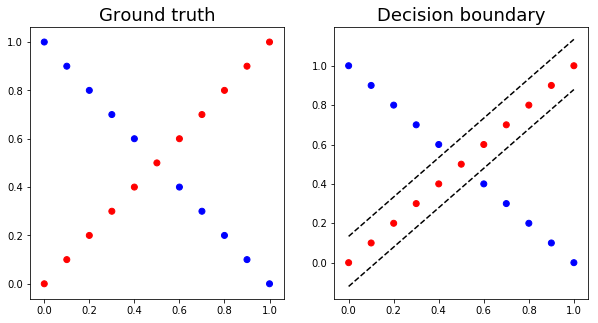

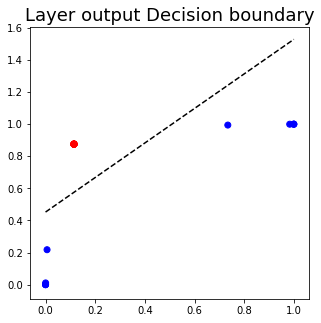

In [13]:
MLP = NN([2,2,1], 10)
x_XOR, y_XOR = generate_XOR_easy()
for _ in range(10000):
    y = MLP.forward(x_XOR)
    loss_XOR = loss(y, y_XOR)
    MLP.backward(derivative_loss(y, y_XOR))
    MLP.update()

y = MLP.forward(x_XOR)
show_data_with_boundary(
    [x_XOR, x_XOR], [y_XOR, np.round(y)], 
    ['Ground truth', 'Decision boundary'], MLP.l[0].w
)
show_data_with_boundary(
    [MLP.l[0].y], [np.round(y)], 
    ['Layer output Decision boundary'], MLP.l[1].w
)